In [1]:
%cd ~/src/laboratori/1516

/home/jovyan/src/laboratori/1516


# **Introduzione al Machine Learning -- laboratorio 15 e 16**

Importa le librerie necessarie (pandas, numpy, matplotlib). Legge il file 'body.xlsx', imposta la prima colonna come indice. Seleziona le colonne 'Height (cm)' come variabile indipendente `x` e 'Weight (kg)' come variabile dipendente `Y`. Crea uno scatter plot di `Y` rispetto a `x`.

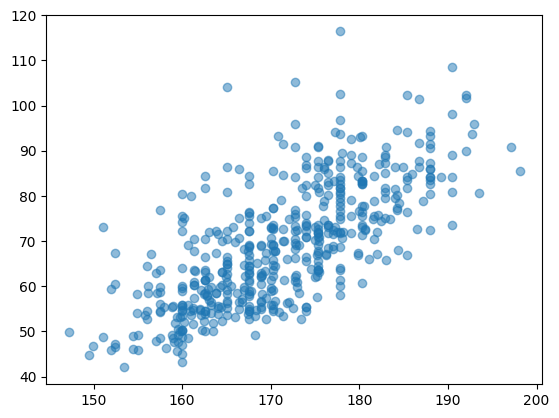

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'body.xlsx'

df = pd.read_excel(filename)
df = df.set_index(df.columns[0])


# Scelgo le variabili per la regressione lineare semplice

x = df['Height (cm)'].values
Y = df['Weight (kg)'].values

plt.scatter(x, Y, alpha=0.5)
plt.show()

Esegue la regressione lineare semplice utilizzando il metodo matriciale. Costruisce la matrice del disegno `C` aggiungendo una colonna di uni a `x`. Calcola la matrice di covarianza dei coefficienti (`cov = (C^T C)^{-1}`). Calcola il vettore dei coefficienti `B = cov C^T Y`. Calcola i valori predetti `pred = C B`. Calcola i residui `resid = Y - pred`. Calcola la somma dei quadrati dei residui (SSR) e la deviazione standard dei residui (`Se`). Visualizza lo scatter plot dei dati originali e sovrappone la retta di regressione calcolata.

cov=array([[ 6.56081987e-01, -3.82198858e-03],
       [-3.82198858e-03,  2.23320323e-05]])
B=array([-105.01125417,    1.01761678])
SSR=43753.0, Se=9.30804


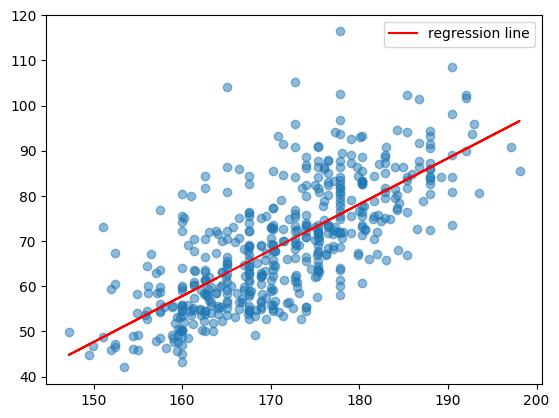

In [3]:
# Risolvo la regressione lineare semplice con il metodo matriciale

C = np.concatenate((np.ones_like(x).reshape(1, -1), x.reshape(1, -1))).T

cov = np.linalg.inv(C.T @ C)
print(f'{cov=}')

B = cov @ C.T @ Y
print(f'{B=}')

pred = C @ B
resid = Y - pred
SSR = np.sum(resid ** 2) # = resid.T @ resid
Se = np.sqrt(SSR / (len(x) - 2))
print(f'{SSR=:.1f}, {Se=:g}')

plt.scatter(x, Y, alpha=0.5)
plt.plot(x, pred, color='red', label='regression line')
plt.legend()
plt.show()

Importa la distribuzione t da `scipy.stats`. Imposta il livello di confidenza `conf`. Calcola il numero di osservazioni `n`, il numero di predittori `p`, i gradi di libertà `df`. Calcola il quantile `q` della distribuzione t necessario per gli intervalli di confidenza. Calcola la matrice `vars = C @ cov @ C.T`, la cui diagonale contiene le varianze delle risposte medie predette per ogni osservazione.

In [4]:
# Aggiungo gli intervalli di confidenza per la risposta media e di predizione per la risposta futura
from scipy.stats import t

conf = 0.95
n = len(x)
p = 1
df = n - p - 1
q = t.ppf((1 + conf) / 2, df) # alpha = 1-conf ; 1 - alpha/2 = 1 - (1-conf)/2 = 1 - 1/2 + conf/2
print(f'{q=:g}')

vars = C @ cov @ C.T # Var(C @ B) = C @ cov @ C.T

q=1.96467


Visualizza le dimensioni (forma) della matrice `vars` calcolata nella cella precedente.

In [5]:
vars.shape

(507, 507)

Calcola la varianza della risposta media predetta per la prima osservazione utilizzando la moltiplicazione matriciale esplicita (`C[0] @ cov @ C[0].T`).

In [6]:
C[0] @ cov @ C[0].T

np.float64(0.0021545702535446594)

Calcola le varianze delle risposte medie predette per tutte le osservazioni (la diagonale di `C @ cov @ C.T`) utilizzando una combinazione di moltiplicazione matriciale ed element-wise (`np.sum((C @ cov) * C, axis=1)`). Visualizza il valore per la prima osservazione per verifica.

In [7]:
vars = np.sum((C @ cov) * C, axis=1)
vars[0]

np.float64(0.002154570253544659)

Calcola i limiti superiori (UCL) e inferiori (LCL) dell'intervallo di confidenza per la risposta media. Calcola i limiti superiori (UPL) e inferiori (LPL) dell'intervallo di predizione per una risposta futura. Visualizza lo scatter plot, la retta di regressione, la banda dell'intervallo di confidenza (arancione) e la banda dell'intervallo di predizione (rosa).

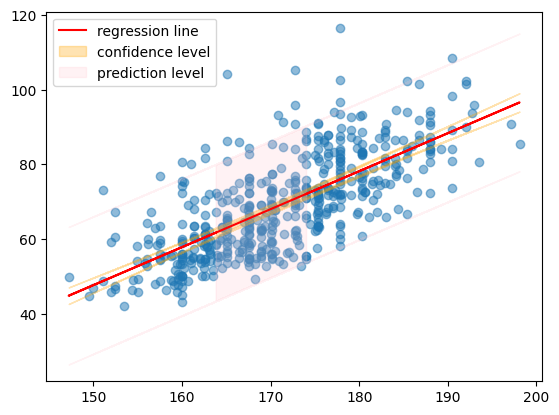

In [8]:
UCL = pred + q * Se * np.sqrt(vars)
LCL = pred - q * Se * np.sqrt(vars)

UPL = pred + q * Se * np.sqrt(1 + vars)
LPL = pred - q * Se * np.sqrt(1 + vars)

plt.scatter(x, Y, alpha=0.5)
plt.plot(x, pred, color='red', label='regression line')
plt.fill_between(x, UCL, LCL, color='orange', alpha=0.3, label='confidence level')
plt.fill_between(x, UPL, LPL, color='pink', alpha=0.2, label='prediction level')
plt.legend()
plt.show()

Definisce il nome di un nuovo file Excel. Legge dati specifici (foglio 'mtst0904.3', colonne 'A:I') da questo file in un nuovo DataFrame `dfm`, impostando la prima colonna come indice.

In [9]:
multireg_filename = 'stin22-lab1718.xlsx'

dfm = pd.read_excel(multireg_filename, sheet_name='mtst0904.3', usecols='A:I', index_col=0)

Importa `seaborn`. Genera una matrice di scatter plot e istogrammi (`pairplot`) per il DataFrame `dfm` per visualizzare le distribuzioni delle singole variabili e le relazioni a coppie tra di esse. Salva il grafico risultante come file PDF.

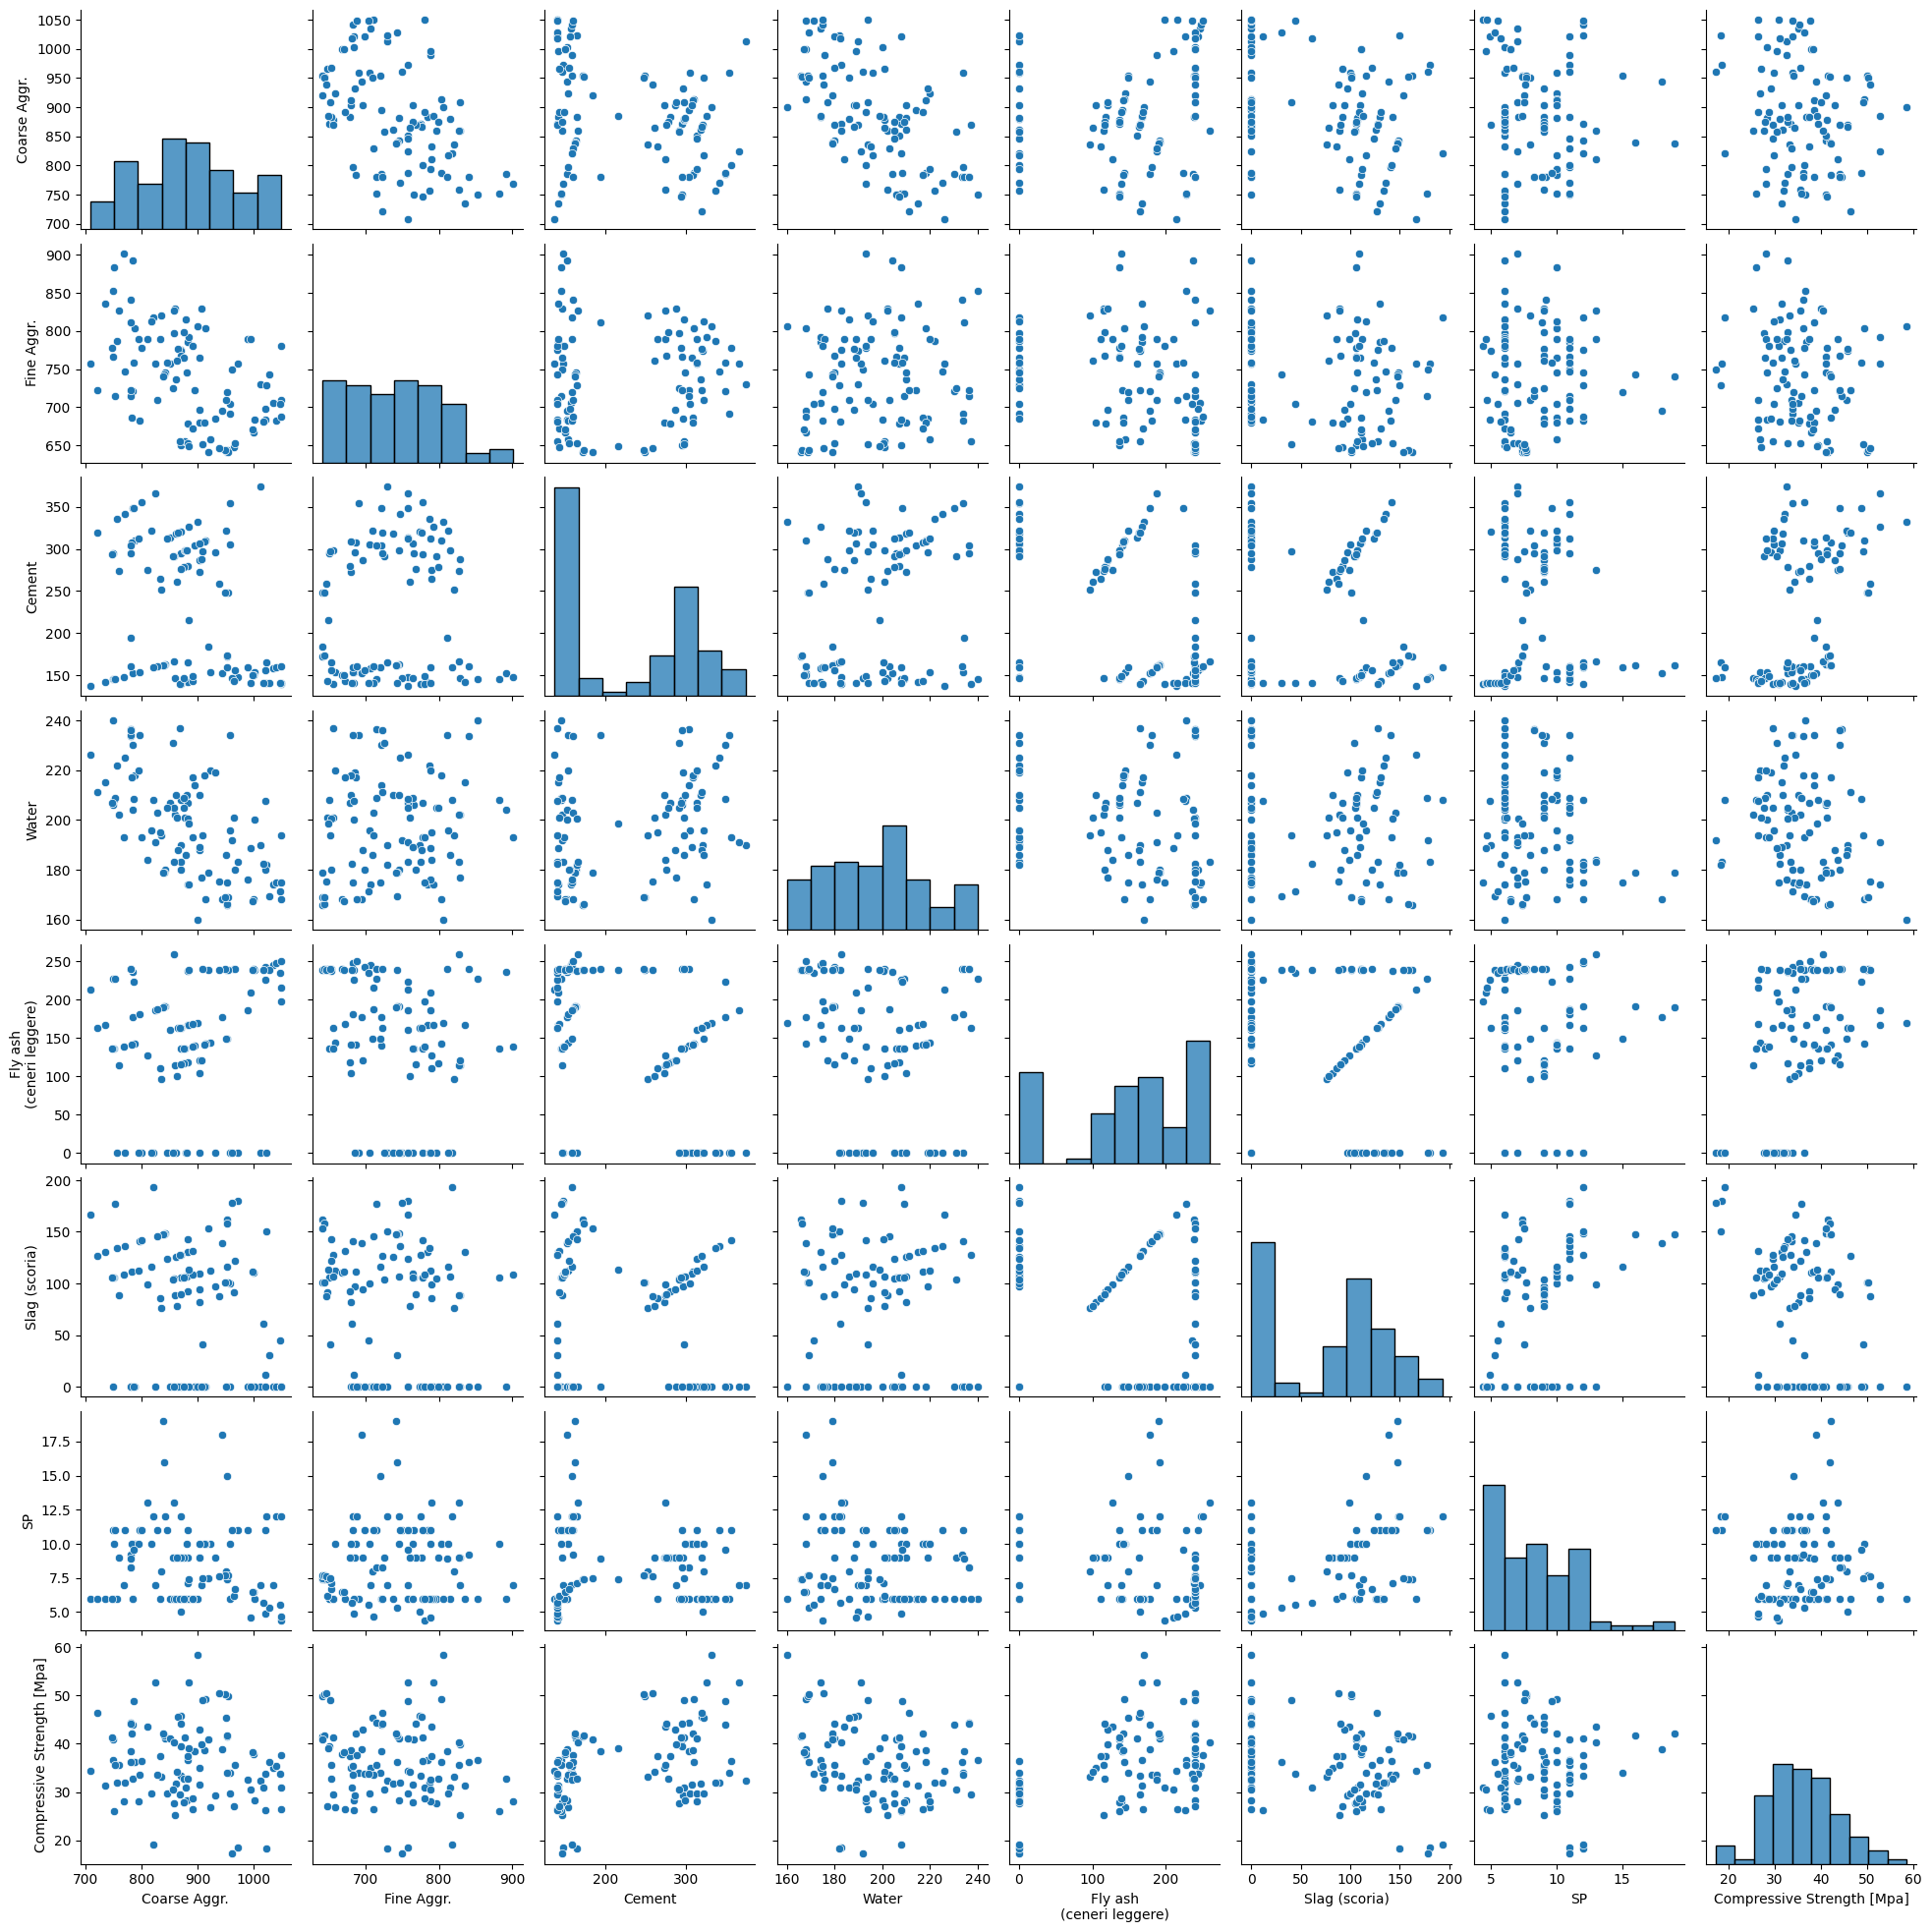

In [10]:
# Diamo sempre un'occhiata alle distribuzioni

import seaborn as sns

pair_plot = sns.pairplot(dfm)
pair_plot.savefig('images/pairplot.pdf')
pair_plot

Non ci sono trasformazioni ovvie da fare sui dati.

Importa `statsmodels.api`. Definisce la variabile dipendente `Y` ('Compressive Strength [Mpa]') e la matrice dei predittori `x_org` (tutte le altre colonne). Aggiunge una costante (intercetta) alla matrice dei predittori `x_org` per creare `x`. Crea un modello di regressione lineare multipla OLS (Ordinary Least Squares) e lo adatta (`fit`) ai dati.

In [11]:
# Regressione lineare multipla

import statsmodels.api as sm

Y = dfm['Compressive Strength [Mpa]']
x_org = dfm.drop(columns='Compressive Strength [Mpa]')
x = sm.add_constant(x_org)

model = sm.OLS(Y, x)
results = model.fit()

Visualizza il sommario completo dei risultati della regressione lineare multipla ottenuti nella cella precedente.

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     Compressive Strength [Mpa]   R-squared:                       0.897
Model:                                    OLS   Adj. R-squared:                  0.889
Method:                         Least Squares   F-statistic:                     117.9
Date:                        Fri, 02 May 2025   Prob (F-statistic):           5.53e-44
Time:                                09:01:40   Log-Likelihood:                -240.76
No. Observations:                         103   AIC:                             497.5
Df Residuals:                              95   BIC:                             518.6
Df Model:                                   7                                         
Covariance Type:                    nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      139.3134     71.957      1.936      0.056      -3.539     282.166
Coarse Aggr.                -0.0555      0.028     -1.996      0.049      -0.111      -0.000
Fine Aggr.                  -0.0389      0.029     -1.334      0.186      -0.097       0.019
Cement                       0.0616      0.023      2.673      0.009       0.016       0.107
Water                       -0.2323      0.073     -3.203      0.002      -0.376      -0.088
Fly ash
(ceneri leggere)     0.0507      0.023      2.165      0.033       0.004       0.097
Slag (scoria)               -0.0294      0.032     -0.917      0.361      -0.093       0.034
SP                           0.1043      0.135      0.774      0.441      -0.163       0.372
==============================================================================
Omnibus:                        7.604   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.217
Skew:                           0.558   Prob(JB):                       0.0271
Kurtosis:                       3.662   Cond. No.                     3.37e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Utilizza la funzione `dir()` per elencare gli attributi e i metodi disponibili nell'oggetto `results` (il risultato del fit del modello), per cercare come accedere alla deviazione standard dei residui (Se).

In [13]:
# Cerchiamo Se

dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 '

Accede e visualizza il valore della statistica F dal sommario dei risultati della regressione.

In [14]:
results.fvalue

np.float64(117.93687313981442)

Accede e visualizza il valore dell'R-quadrato aggiustato (`rsquared_adj`) dal sommario dei risultati della regressione.

In [15]:
results.rsquared_adj

np.float64(0.8891976523016507)

Accede e visualizza l'errore quadratico medio dei residui (`mse_resid`), che corrisponde al quadrato della deviazione standard dei residui (Se^2), dai risultati della regressione.

In [16]:
results.mse_resid # Se^2

np.float64(6.8074611298341745)

Calcola la deviazione standard dei residui (`Se`) prendendo la radice quadrata di `results.mse_resid` e la visualizza formattata.

In [17]:
Se = np.sqrt(results.mse_resid)
print(f'{Se=:.4f}')

Se=2.6091


Definisce una funzione `plot_resid` che genera grafici dei residui: un grafico dei residui rispetto ai valori predetti e un grafico dei residui rispetto a ciascuna variabile predittrice (escludendo opzionalmente la costante). Chiama la funzione `plot_resid` per visualizzare i grafici dei residui del primo modello (`results`).

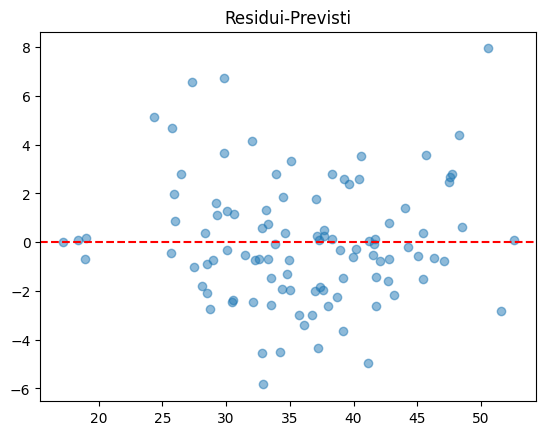

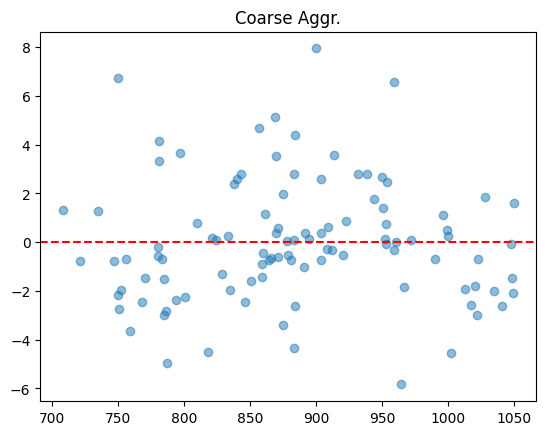

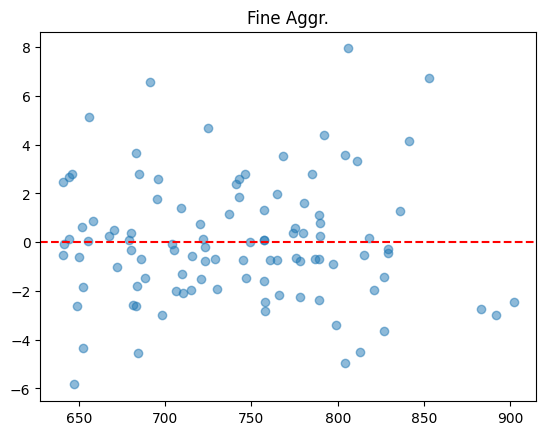

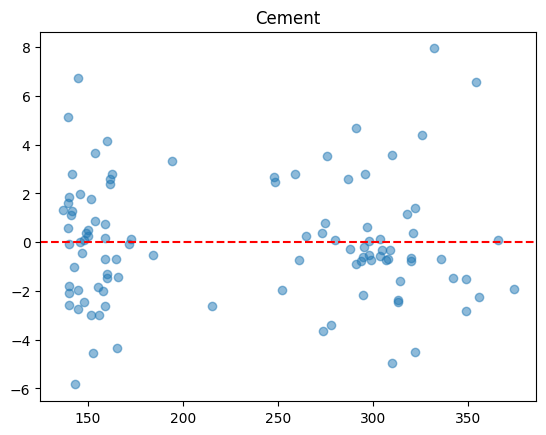

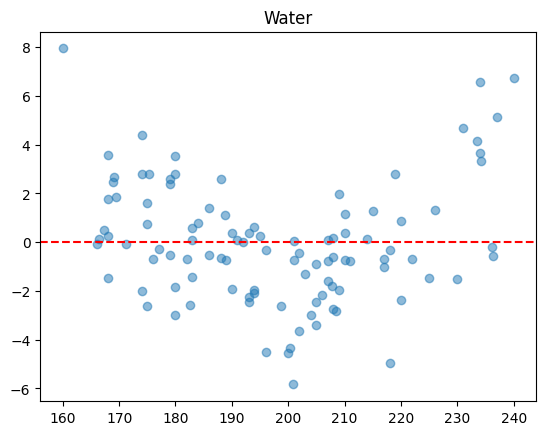

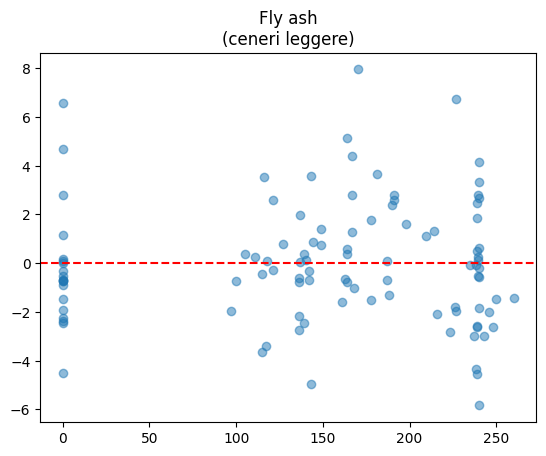

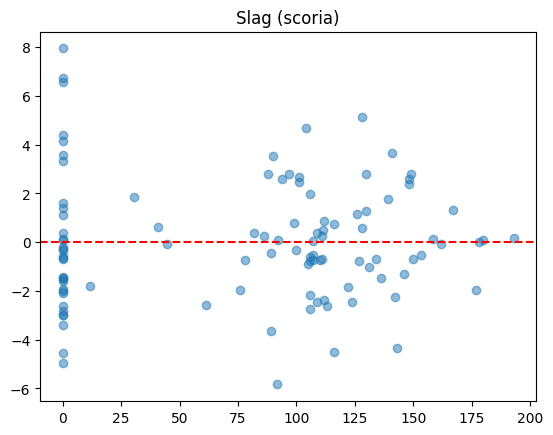

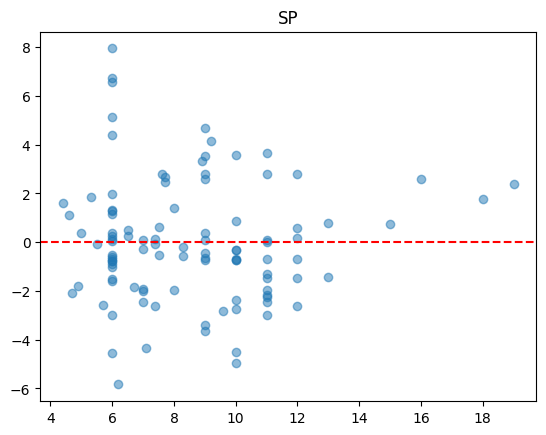

In [18]:
# Facciamo i grafici dei residui

def plot_resid(x, results, skip_first=True):
    plt.scatter(results.fittedvalues, results.resid, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residui-Previsti')
    plt.show()

    first = 1 if skip_first else 0

    for var in x.columns[first:]:
        plt.scatter(x[var], results.resid, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(var)
        plt.show()

plot_resid(x, results)

Osservando una possibile non linearità nel grafico dei residui rispetto a 'Water', aggiunge un termine quadratico per questa variabile (`Water^2`) alla matrice dei predittori `x`.

In [19]:
# Siccome c'e' una evidente dipendenza non lineare da water, aggiungiamo un termine non lineare

x['Water^2'] = x['Water'] ** 2

Crea e adatta un secondo modello OLS (`model2`, `results2`) utilizzando la matrice dei predittori `x` aggiornata (con il termine `Water^2`). Stampa la nuova deviazione standard dei residui (`Se`) e il sommario completo del modello. Chiama `plot_resid` per visualizzare i grafici dei residui di questo secondo modello.

Se: 1.9435
                                OLS Regression Results                                
Dep. Variable:     Compressive Strength [Mpa]   R-squared:                       0.943
Model:                                    OLS   Adj. R-squared:                  0.939
Method:                         Least Squares   F-statistic:                     195.6
Date:                        Fri, 02 May 2025   Prob (F-statistic):           4.18e-55
Time:                                09:01:40   Log-Likelihood:                -209.88
No. Observations:                         103   AIC:                             437.8
Df Residuals:                              94   BIC:                             461.5
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

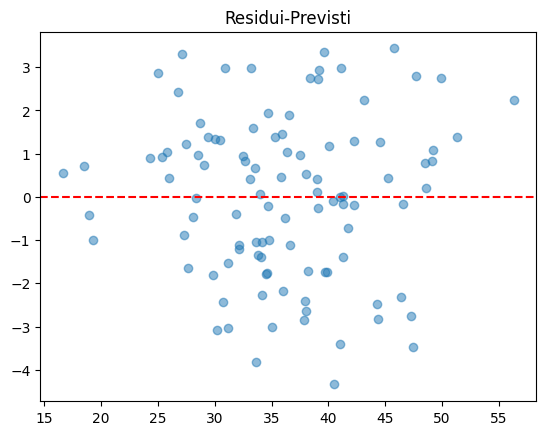

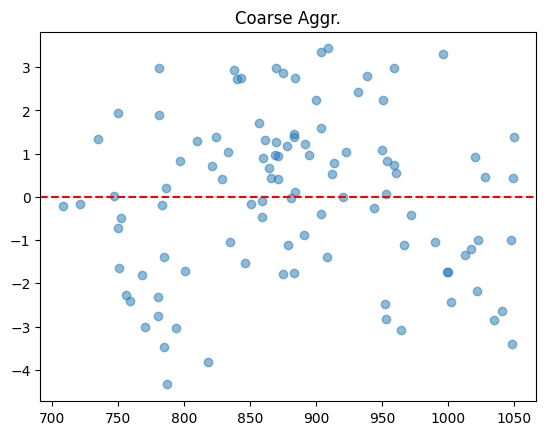

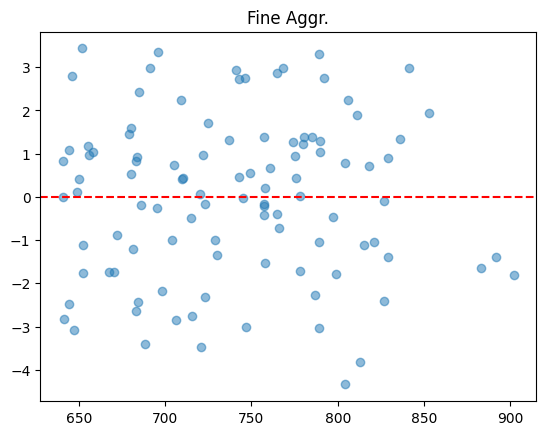

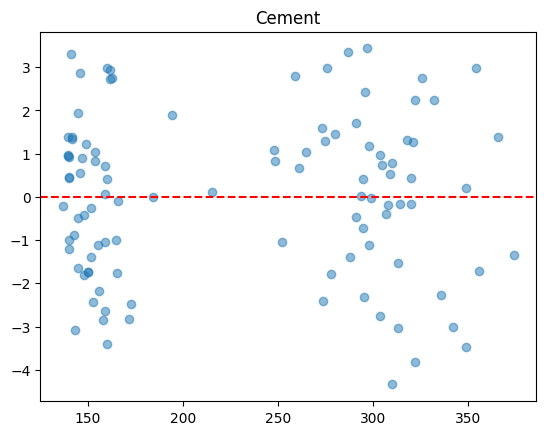

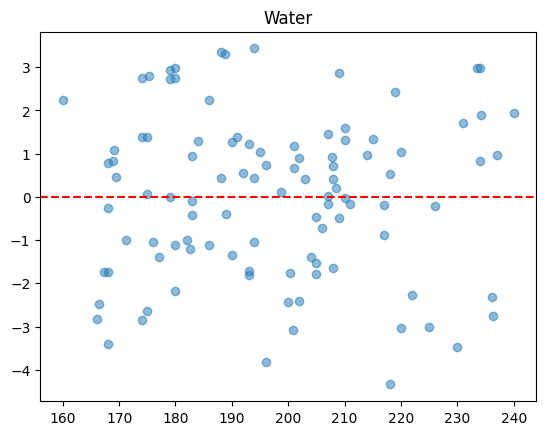

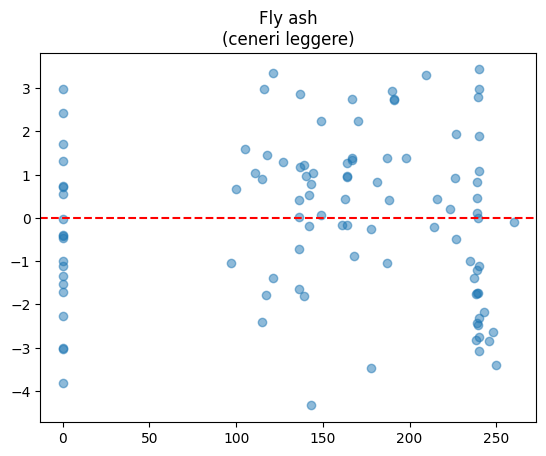

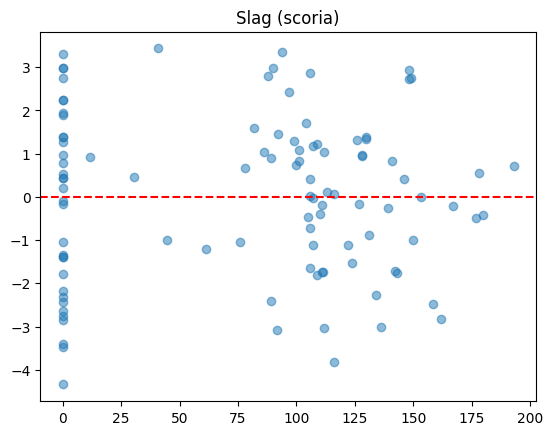

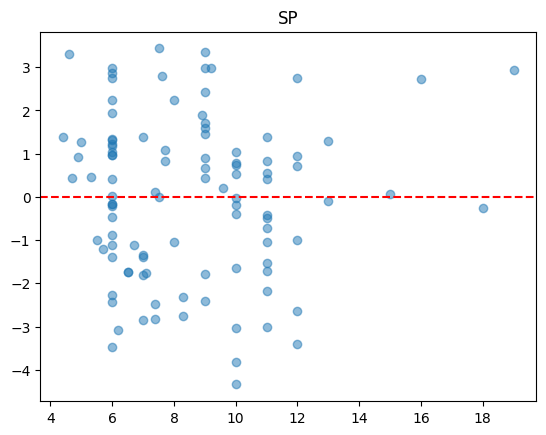

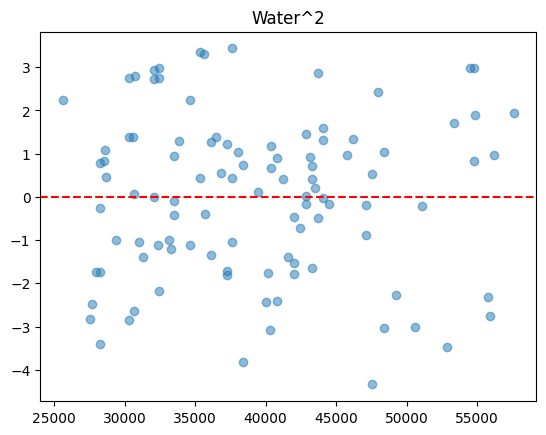

In [20]:
model2 = sm.OLS(Y, x)
results2 = model2.fit()

print(f'Se: {np.sqrt(results2.mse_resid):g}')
print(results2.summary())

plot_resid(x, results2)

Crea una copia della matrice dei predittori `x` in `x2`. Itera sulle colonne della matrice dei predittori originali `x_org`. Per ogni variabile diversa da 'Water', aggiunge a `x2` un termine di interazione tra 'Water' e quella variabile.

In [21]:
# Proviamo ad aggiungere le interazioni tra Water e le altre variabili

x2 = x.copy()

for var in x_org.columns:
  if var == 'Water':
    continue
  x2[f'Water*{var}'] = x['Water'] * x[var]

Visualizza la matrice dei predittori `x2`, che ora contiene la costante, i termini lineari originali, il termine quadratico `Water^2` e tutti i termini di interazione tra 'Water' e le altre variabili.

In [22]:
x2

,const,Coarse Aggr.,Fine Aggr.,Cement,Water,Fly ash\n(ceneri leggere),Slag (scoria),SP,Water^2,Water*Coarse Aggr.,Water*Fine Aggr.,Water*Cement,Water*Fly ash\n(ceneri leggere),Water*Slag (scoria),Water*SP
No,,,,,,,,,,,,,,,
1,1.0,904.0,680.0,273.0,210.0,105.0,82.0,9.0,44100.00,189840.00,142800.00,57330.00,22050.00,17220.0,1890.00
2,1.0,843.0,746.0,163.0,180.0,191.0,149.0,12.0,32400.00,151740.00,134280.00,29340.00,34380.00,26820.0,2160.00
3,1.0,840.0,743.0,162.0,179.0,191.0,148.0,16.0,32041.00,150360.00,132997.00,28998.00,34189.00,26492.0,2864.00
4,1.0,838.0,741.0,162.0,179.0,190.0,148.0,19.0,32041.00,150002.00,132639.00,28998.00,34010.00,26492.0,3401.00
5,1.0,923.0,658.0,154.0,220.0,144.0,112.0,10.0,48400.00,203060.00,144760.00,33880.00,31680.00,24640.0,2200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1.0,954.2,640.6,248.3,168.9,239.1,101.0,7.7,28527.21,161164.38,108197.34,41937.87,40383.99,17058.9,1300.53
100,1.0,949.9,644.1,248.0,169.1,239.9,101.0,7.7,28594.81,160628.09,108917.31,41936.80,40567.09,17079.1,1302.07
101,1.0,938.9,646.0,258.8,175.3,239.6,88.0,7.6,30730.09,164589.17,113243.80,45367.64,42001.88,15426.4,1332.28


Crea e adatta un terzo modello OLS (`model3`, `results3`) utilizzando la matrice dei predittori `x2` (con termine quadratico e tutte le interazioni con 'Water'). Stampa la deviazione standard dei residui (`Se`) e il sommario completo del modello. Chiama `plot_resid` per visualizzare i grafici dei residui di questo terzo modello, plottando rispetto ai predittori originali `x_org`.

Se: 1.65563
                                OLS Regression Results                                
Dep. Variable:     Compressive Strength [Mpa]   R-squared:                       0.962
Model:                                    OLS   Adj. R-squared:                  0.955
Method:                         Least Squares   F-statistic:                     157.0
Date:                        Fri, 02 May 2025   Prob (F-statistic):           7.21e-56
Time:                                09:01:41   Log-Likelihood:                -189.98
No. Observations:                         103   AIC:                             410.0
Df Residuals:                              88   BIC:                             449.5
Df Model:                                  14                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------

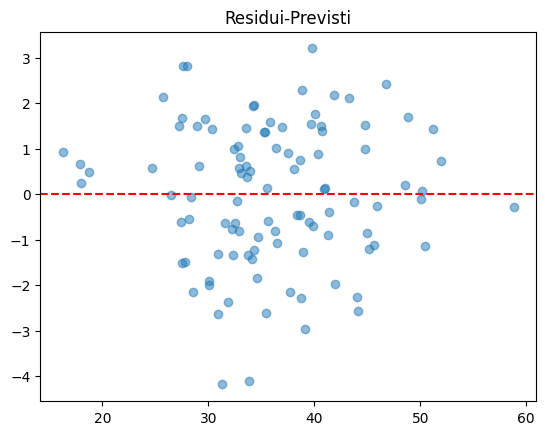

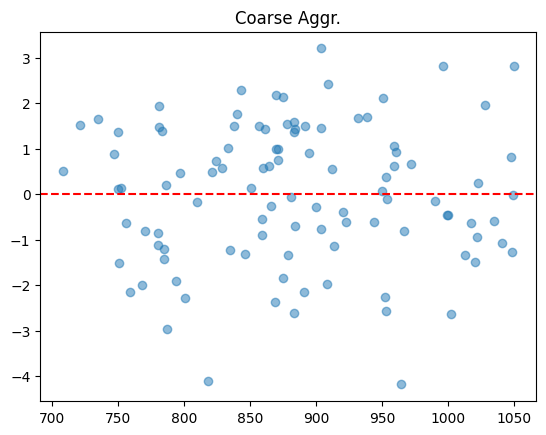

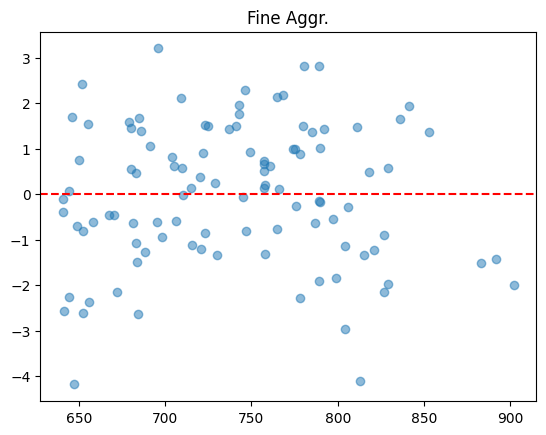

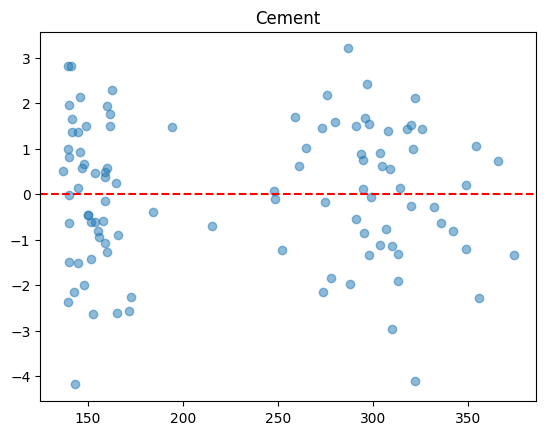

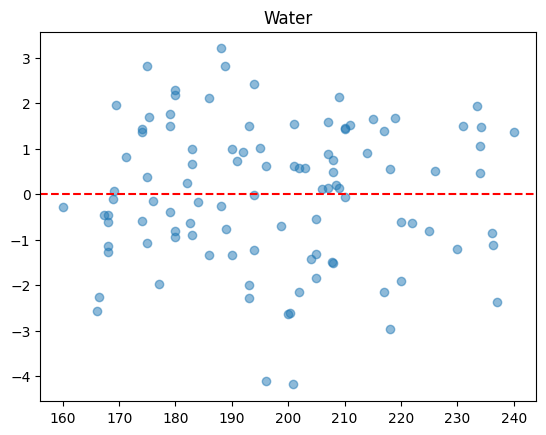

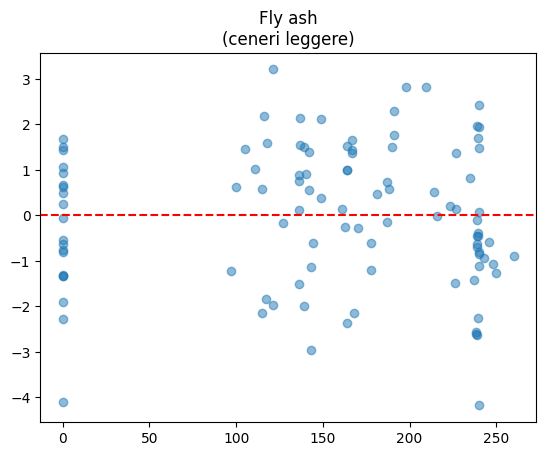

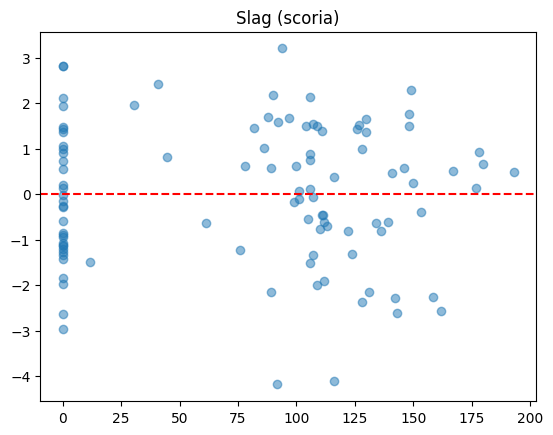

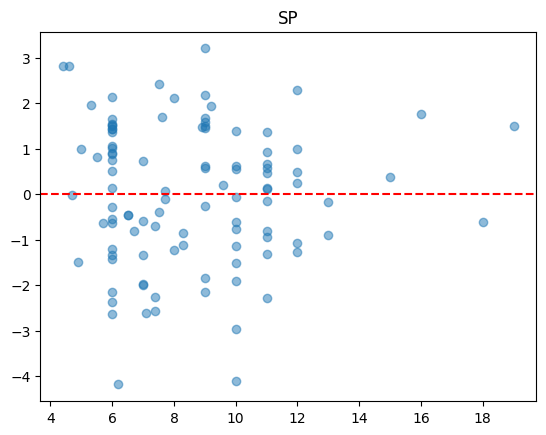

In [23]:
model3 = sm.OLS(Y, x2)
results3 = model3.fit()
print(f'Se: {np.sqrt(results3.mse_resid):g}')
print(results3.summary())
plot_resid(x_org, results3, skip_first=False)

Esegue una procedura di selezione: itera sulle colonne dei predittori originali `x_org`. Per ogni variabile diversa da 'Water', crea una matrice temporanea `x_tmp` aggiungendo a `x` (che contiene già `Water^2`) *solo* il termine di interazione tra 'Water' e la variabile corrente. Adatta un modello temporaneo e stampa la deviazione standard dei residui (`Se`) associata a quel modello e il nome della variabile di interazione. Questo aiuta a identificare quale singolo termine di interazione riduce maggiormente l'errore.

In [24]:
# Proviamo ad aggiungere le interazioni tra Water e le altre variabili, una per volta

for var in x_org.columns:
    if var == 'Water':
        continue
    x_tmp = x.copy()
    x_tmp[f'Water*{var}'] = x['Water'] * x[var]
    model_tmp = sm.OLS(Y, x_tmp)
    results_tmp = model_tmp.fit()
    print(f'Se: {np.sqrt(results_tmp.mse_resid):g} {var}')
    # print(results_tmp.summary())

Se: 1.72094 Coarse Aggr.
Se: 1.92454 Fine Aggr.
Se: 1.80049 Cement
Se: 1.94834 Fly ash
(ceneri leggere)
Se: 1.95392 Slag (scoria)
Se: 1.94371 SP


Basandosi sui risultati della cella precedente, seleziona l'interazione 'Water * Coarse Aggr.' come la più promettente. Crea una nuova matrice dei predittori `x3` aggiungendo solo questo termine di interazione a `x` (che contiene già `Water^2`). Crea e adatta un quarto modello OLS (`model4`, `results4`). Stampa la deviazione standard dei residui (`Se`) e il sommario completo del modello. Chiama `plot_resid` per visualizzare i grafici dei residui di questo quarto modello.

Se: 1.72094
                                OLS Regression Results                                
Dep. Variable:     Compressive Strength [Mpa]   R-squared:                       0.956
Model:                                    OLS   Adj. R-squared:                  0.952
Method:                         Least Squares   F-statistic:                     224.8
Date:                        Fri, 02 May 2025   Prob (F-statistic):           4.72e-59
Time:                                09:01:41   Log-Likelihood:                -196.81
No. Observations:                         103   AIC:                             413.6
Df Residuals:                              93   BIC:                             440.0
Df Model:                                   9                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

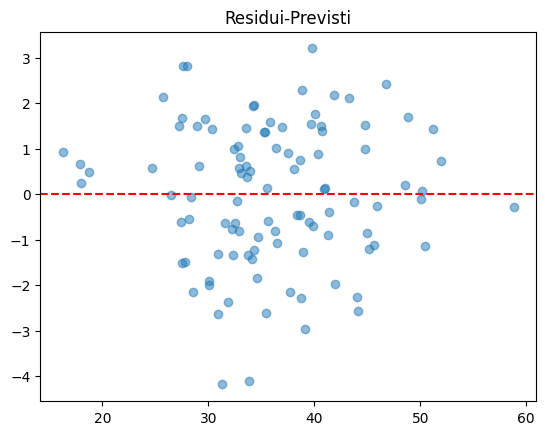

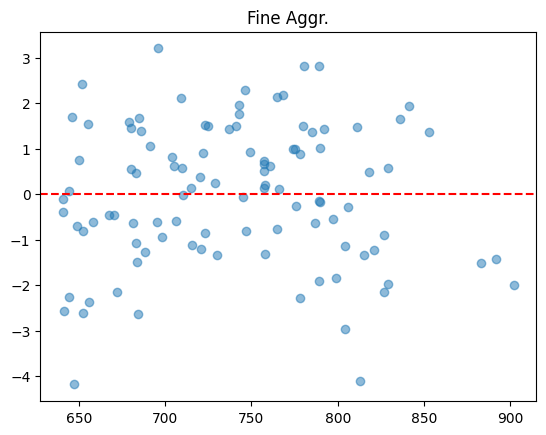

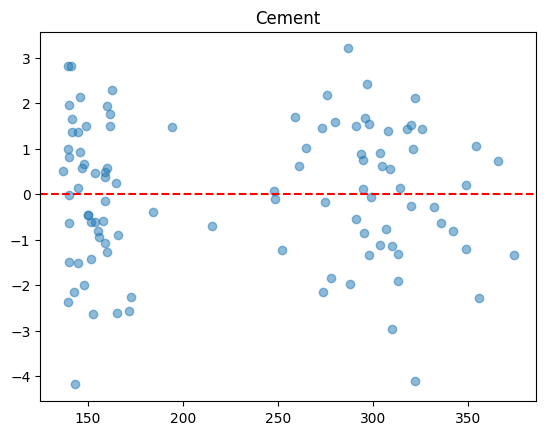

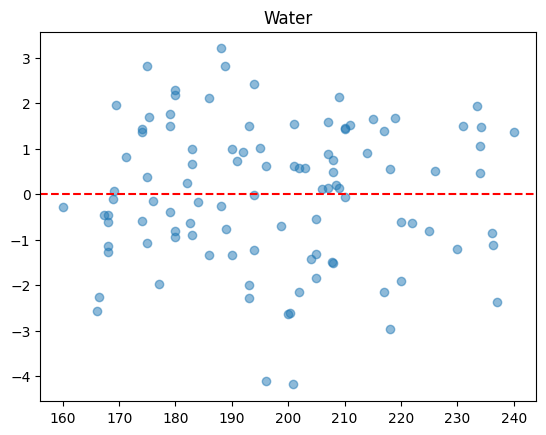

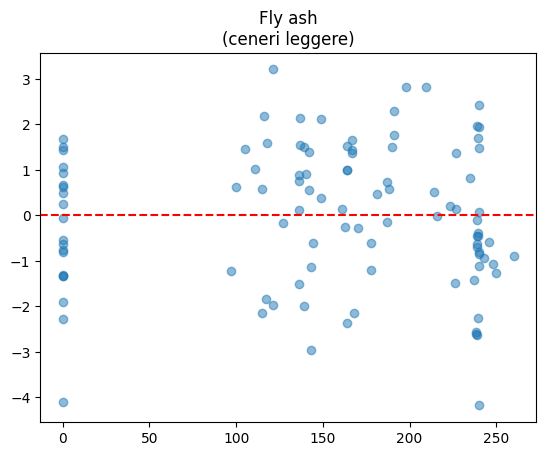

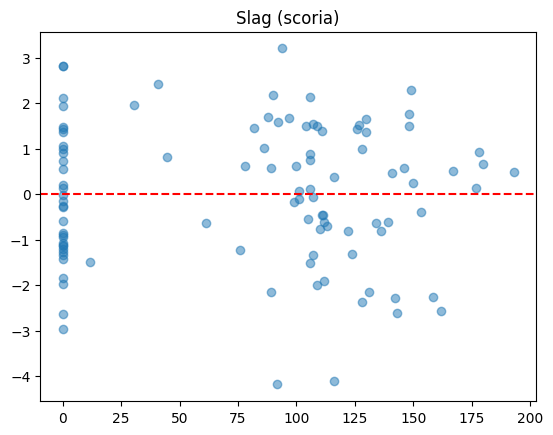

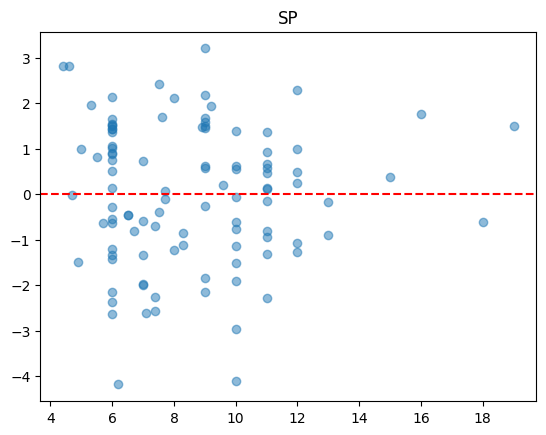

In [25]:
# Aggiungo solo Coarse Aggr. che è la migliore

var = 'Coarse Aggr.'
x3 = x.copy()
x3[f'Water*{var}'] = x['Water'] * x[var]
model4 = sm.OLS(Y, x3)
results4 = model4.fit()
print(f'Se: {np.sqrt(results4.mse_resid):g}')
print(results4.summary())
plot_resid(x_org, results3)